## 3-Invariant function with HyperGraph for Hyper Max Cilque

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from QUBO_formulation.qubo import solve_graph, solve_weighted_graph, definite_graph_to_qubo, weighted_graph_to_qubo, n_invariant_ordinary_graph_to_qubo, hypergraph_to_qubo
from Solvers.solver import solve_qubo
from evaluation import evaluate

In [2]:
mnist = pd.read_csv('MNIST_dataset/test.csv')
mnist.head(5)

,label,x0,y0,v0,x1,y1,v1,x2,y2,v2,...,v347,x348,y348,v348,x349,y349,v349,x350,y350,v350
0,7,14,7,254,21,18,140,21,17,106,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,17,6,253,16,19,253,10,7,253,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,16,18,223,10,4,5,15,13,165,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,17,8,253,20,17,105,14,20,251,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,18,17,18,10,11,85,17,4,236,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [3]:
mnist = mnist.drop('label', axis = 1)

In [4]:
size = 20

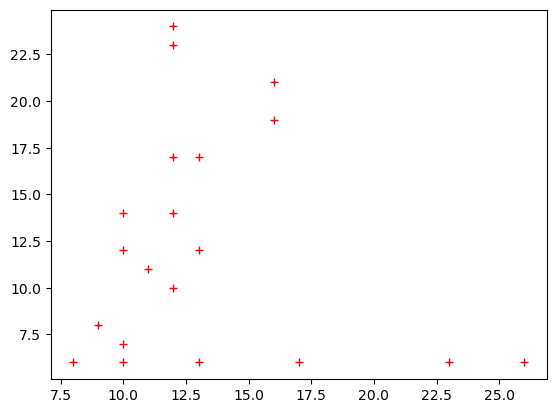

In [5]:
mapping = np.arange(3*size).reshape(-1, 3)
inds = mapping[:, :2]
val_ind = mapping[:, 2]
img = np.zeros((28, 28))
fisrt_img = mnist.to_numpy()[1]
coordinates = fisrt_img[inds]
img[coordinates[:,0], coordinates[:, 1]] = 1
plt.plot(coordinates[:,0], coordinates[:, 1], '+',color='red',)


In [6]:
mu, sigma = 0, 0.1 # mean and standard deviation
s1 = np.random.normal(mu, sigma, size)
s2 = np.random.normal(mu, sigma, size)

In [7]:
sqrt2d2 = np.sqrt(2)/2
R = np.eye(2) #np.array([[sqrt2d2, sqrt2d2], [-sqrt2d2, sqrt2d2]])
t = np.array([0, 0])
noise = np.hstack((s1.reshape(-1, 1), s2.reshape(-1, 1)))

In [8]:
from problem_instance.twoD_point_cloud_registeration import model, pairwise_compatibility_value, definite_graph, area_invariant_compatibility_test

(0.7200000000000001, 1.32)


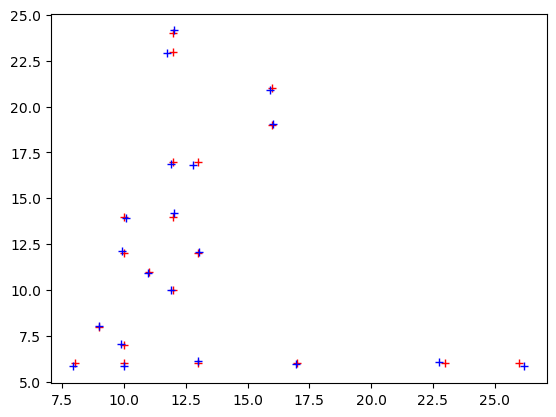

In [9]:
new_coord = model(R, t, coordinates, noise)
plt.plot(coordinates[:,0], coordinates[:, 1], '+', color='red')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='blue',)

In [10]:
outlier_rate = 0.1
num_out = int(outlier_rate * size)

In [11]:
outliers = 28 * np.random.rand(num_out, 2) # 20 outliers points in 2D
outliers_cord_t = model(R, t, outliers, np.zeros((num_out, 2)))

In [12]:
new_coord_with_outliers = np.vstack((new_coord[:-num_out], outliers_cord_t))
inlier_mask = np.zeros(size, dtype=bool)
inlier_mask[:-num_out] = True

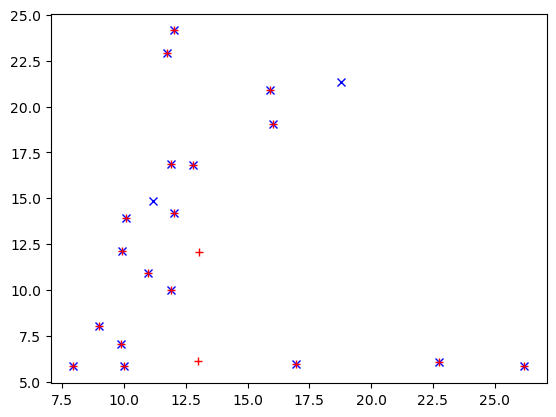

In [13]:
plt.plot(new_coord_with_outliers[:,0], new_coord_with_outliers[:, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')

In [14]:
perm = np.random.permutation(size)
new_coord_with_outliers = new_coord_with_outliers[perm]
coordinates = coordinates[perm]
inlier_perm_mask = inlier_mask[perm]

## N-invariant

In [15]:
H = area_invariant_compatibility_test(coordinates, new_coord_with_outliers, 0.79, fail_edge=True)

In [17]:
Q, b = hypergraph_to_qubo(H, 1)

(20,)


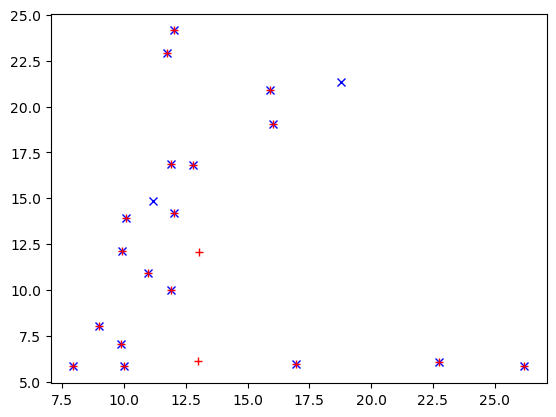

In [18]:
sl = solve_qubo(Q, b, "dwave_annealing")[:size]
sol = np.argwhere(sl == 1).reshape(-1)
print(sol.shape)
plt.plot(new_coord_with_outliers[sol, 0], new_coord_with_outliers[sol, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')

In [19]:
evaluate(size, inlier_perm_mask, sl)

Overall Accuracy:  0.9
Inlier Preserved Rate:  1.0
Outlier Rejected Rate:  0.0


(12,)
Overall Accuracy:  0.7
Inlier Preserved Rate:  0.6666666666666666
Outlier Rejected Rate:  1.0


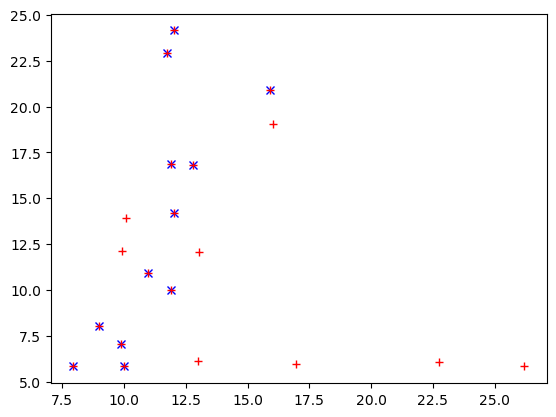

In [24]:
Q, b = hypergraph_to_qubo(H, 2)
sl = solve_qubo(Q, b, "dwave_annealing")[:size]
sol = np.argwhere(sl == 1).reshape(-1)
print(sol.shape)
plt.plot(new_coord_with_outliers[sol, 0], new_coord_with_outliers[sol, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')
evaluate(size, inlier_perm_mask, sl)

In [21]:
slg = solve_qubo(Q, b, "gurobi")
solg = np.argwhere(slg == 1).reshape(-1)
print(solg.shape)
plt.plot(new_coord_with_outliers[solg, 0], new_coord_with_outliers[solg, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [ ]:
evaluate(size, inlier_perm_mask, slg)

Overall Accuracy:  0.8
Inlier Preserved Rate:  1.0
Outlier Rejected Rate:  0.0
